In [1]:
!pip install transformers datasets scikit-learn torch -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 📂 Load and combine data
df1 = pd.read_csv("/content/Train_data.csv")[['text', 'label']]
df2 = pd.read_csv("/content/medical_data.csv").rename(columns={"Patient_Problem": "text", "Disease": "label"})[['text', 'label']]
df_all = pd.concat([df1, df2]).reset_index(drop=True)

# Label encoding
le = LabelEncoder()
df_all["label"] = le.fit_transform(df_all["label"])
num_labels = len(le.classes_)

# Tokenizer setup for ClinicalBERT
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class MedicalDataset(Dataset):
    def __init__(self, texts, labels):
        enc = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
        self.encodings, self.labels = enc, torch.tensor(labels)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Split data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(df_all["text"].tolist(), df_all["label"].tolist(), test_size=0.2)

# Create DataLoader for train and test sets
train_loader = DataLoader(MedicalDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(MedicalDataset(X_test, y_test), batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [3]:
# Initialize the ClinicalBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Setup optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Tracking training and validation loss
train_losses, val_losses = [], []

# Training loop
model.train()
for epoch in range(10):  # Train for 10 epochs
    print(f"\nEpoch {epoch + 1}")
    total_train_loss = 0
    for batch in tqdm(train_loader):  # Training loop
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss calculation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss = model(**batch).loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")



Epoch 1


100%|██████████| 81/81 [14:37<00:00, 10.83s/it]


Train Loss: 4.8490 | Validation Loss: 4.2745

Epoch 2


100%|██████████| 81/81 [13:48<00:00, 10.23s/it]


Train Loss: 3.8115 | Validation Loss: 3.3841

Epoch 3


100%|██████████| 81/81 [13:46<00:00, 10.20s/it]


Train Loss: 2.8998 | Validation Loss: 2.6247

Epoch 4


100%|██████████| 81/81 [13:43<00:00, 10.17s/it]


Train Loss: 2.1452 | Validation Loss: 2.0896

Epoch 5


100%|██████████| 81/81 [13:48<00:00, 10.23s/it]


Train Loss: 1.6461 | Validation Loss: 1.6938

Epoch 6


100%|██████████| 81/81 [13:56<00:00, 10.33s/it]


Train Loss: 1.2992 | Validation Loss: 1.4797

Epoch 7


100%|██████████| 81/81 [13:52<00:00, 10.28s/it]


Train Loss: 1.1103 | Validation Loss: 1.3618

Epoch 8


100%|██████████| 81/81 [13:45<00:00, 10.20s/it]


Train Loss: 0.9563 | Validation Loss: 1.3000

Epoch 9


100%|██████████| 81/81 [13:47<00:00, 10.21s/it]


Train Loss: 0.8415 | Validation Loss: 1.1964

Epoch 10


100%|██████████| 81/81 [14:16<00:00, 10.57s/it]


Train Loss: 0.7510 | Validation Loss: 1.1685


In [6]:
# 🧪 Evaluation
import numpy as np  # Import numpy here

model.eval()
preds, labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch).logits
        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

# 🎯 Classification Report and Metrics
used_labels = np.unique(labels)  # This is where NumPy is needed
used_names = le.inverse_transform(used_labels)
print("\n✅ Classification Report:\n")
print(classification_report(labels, preds, labels=used_labels, target_names=used_names))
print("\n✅ Accuracy:", accuracy_score(labels, preds))
print("✅ Precision:", precision_score(labels, preds, average="weighted"))
print("✅ Recall:", recall_score(labels, preds, average="weighted"))
print("✅ F1 Score:", f1_score(labels, preds, average="weighted"))




✅ Classification Report:

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        11
              Allergic Rhinitis       0.00      0.00      0.00         1
                Alopecia Areata       0.00      0.00      0.00         1
            Alzheimer's Disease       0.00      0.00      0.00         1
                    Anaphylaxis       0.00      0.00      0.00         1
               Anxiety Disorder       0.00      0.00      0.00         1
                   Appendicitis       1.00      0.50      0.67         2
                      Arthritis       1.00      1.00      1.00         5
            Atrial Fibrillation       0.00      0.00      0.00         2
               Bipolar Disorder       1.00      1.00      1.00         2
               Bronchial Asthma       0.89      1.00      0.94        16
                     Bronchitis       0.00      0.00      0.00         1
                       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

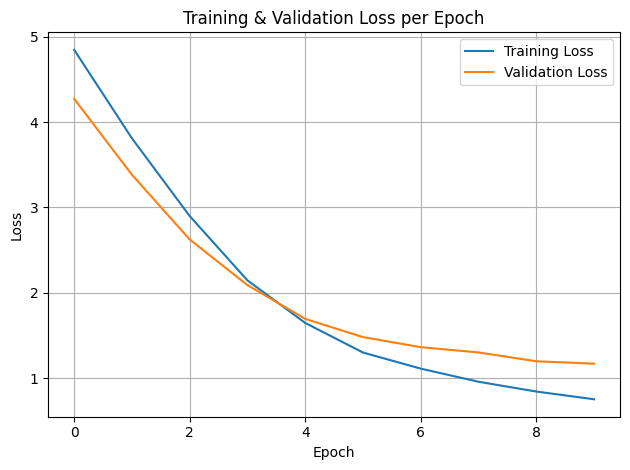

In [7]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
